In [1]:
#!g1.1
import torch
import matplotlib.pyplot as plt

In [2]:
#!g1.1
import torchvision.transforms as T
from torchvision.datasets import OxfordIIITPet

dataset = OxfordIIITPet('/home/jupyter/mnt/datasets/pets', target_types='segmentation', download=True)

100%|██████████| 791918971/791918971 [00:28<00:00, 27770244.31it/s]


Extracting /home/jupyter/mnt/datasets/pets/oxford-iiit-pet/images.tar.gz to /home/jupyter/mnt/datasets/pets/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 12192886.22it/s]


Extracting /home/jupyter/mnt/datasets/pets/oxford-iiit-pet/annotations.tar.gz to /home/jupyter/mnt/datasets/pets/oxford-iiit-pet


In [3]:
#!g1.1
transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.ToTensor(),
    ]
)

target_transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.PILToTensor(),
        T.Lambda(lambda x: (x - 1).long())
    ]
)

train_dataset = OxfordIIITPet('/home/jupyter/mnt/datasets/pets', transform=transform, target_transform=target_transform, target_types='segmentation')
valid_dataset = OxfordIIITPet('/home/jupyter/mnt/datasets/pets', transform=transform, split='test', target_transform=target_transform, target_types='segmentation')

In [4]:
#!g1.1
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
#!g1.1
from tqdm import tqdm


def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [6]:
#!g1.1
@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        total_loss += loss.item()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [7]:
#!g1.1
from IPython.display import clear_output


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [8]:
#!g1.1
import numpy as np
from PIL import Image


@torch.inference_mode()
def visualize(model, batch):
    model.eval()

    xs, ys = batch

    to_pil = T.ToPILImage()

    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = model(x.unsqueeze(0).cuda()).squeeze(0).max(dim=0)[1]

        fig, ax = plt.subplots(1, 3, figsize=(24, 8), facecolor='white')

        ax[0].imshow(to_pil(x))
        ax[1].imshow(to_pil(y.to(torch.uint8)))
        ax[2].imshow(to_pil(prediction.to(torch.uint8)))

        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')

        ax[0].set_title('Original image')
        ax[1].set_title('Segmentation mask')
        ax[2].set_title('Prediction')

        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        if i >= 9:
            break

In [9]:
#!g1.1
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        visualize(model, next(iter(valid_loader)))
        if valid_accuracy>0.88:
          break

In [10]:
import torch
import torch.nn as nn

def conv_plus_conv(in_channels, out_channels):
    """
    Создает блок UNet
    :param in_channels: входные каналы
    :param out_channels: выходные каналы
    :return: блок UNet
    """
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
    )

class UNET(nn.Module):
    def __init__(self):
        super().__init__()

        base_channels = 32  # Увеличиваем базовое количество каналов

        # Определяем блоки свертки для down-sampling
        self.down1 = conv_plus_conv(3, base_channels)
        self.down2 = conv_plus_conv(base_channels, base_channels * 2)
        self.down3 = conv_plus_conv(base_channels * 2, base_channels * 4)
        self.down4 = conv_plus_conv(base_channels * 4, base_channels * 8)
        # Добавляем дополнительные блоки down-sampling
        self.down5 = conv_plus_conv(base_channels * 8, base_channels * 16)
        self.down6 = conv_plus_conv(base_channels * 16, base_channels * 32)

        # Определяем bottleneck
        self.bottleneck = conv_plus_conv(base_channels * 32, base_channels * 32)

        # Определяем блоки свертки для up-sampling
        self.up6 = conv_plus_conv(base_channels * 32 * 2, base_channels * 16)
        self.up5 = conv_plus_conv(base_channels * 16 * 2, base_channels * 8)
        self.up4 = conv_plus_conv(base_channels * 8 * 2, base_channels * 4)
        self.up3 = conv_plus_conv(base_channels * 4 * 2, base_channels * 2)
        self.up2 = conv_plus_conv(base_channels * 2 * 2, base_channels)
        # Добавляем дополнительные блоки up-sampling
        self.up1 = conv_plus_conv(base_channels * 2, base_channels)

        # Определяем выходной слой
        self.out = nn.Conv2d(in_channels=base_channels, out_channels=3, kernel_size=1)

        # Определяем операции downsample и upsample
        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        # Проходим через блоки down-sampling, сохраняя residual для каждого блока
        residual1 = self.down1(x)
        x = self.downsample(residual1)
        residual2 = self.down2(x)
        x = self.downsample(residual2)
        residual3 = self.down3(x)
        x = self.downsample(residual3)
        residual4 = self.down4(x)
        x = self.downsample(residual4)
        residual5 = self.down5(x)
        x = self.downsample(residual5)
        residual6 = self.down6(x)
        x = self.downsample(residual6)

        # Проходим через bottleneck
        x = self.bottleneck(x)

        # Проходим через блоки up-sampling, используя операцию cat для конкатенации
        x = self.upsample(x)
        x = torch.cat((x, residual6), dim=1)
        x = self.up6(x)

        x = self.upsample(x)
        x = torch.cat((x, residual5), dim=1)
        x = self.up5(x)

        x = self.upsample(x)
        x = torch.cat((x, residual4), dim=1)
        x = self.up4(x)

        x = self.upsample(x)
        x = torch.cat((x, residual3), dim=1)
        x = self.up3(x)

        x = self.upsample(x)
        x = torch.cat((x, residual2), dim=1)
        x = self.up2(x)

        x = self.upsample(x)
        x = torch.cat((x, residual1), dim=1)
        x = self.up1(x)

        # Применяем выходной слой
        x = self.out(x)

        return x


In [11]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

loss_fn = nn.CrossEntropyLoss()

cuda:0
Tesla P100-PCIE-16GB


In [12]:
#!g1.1
from torch.optim import Adam

model = UNET().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

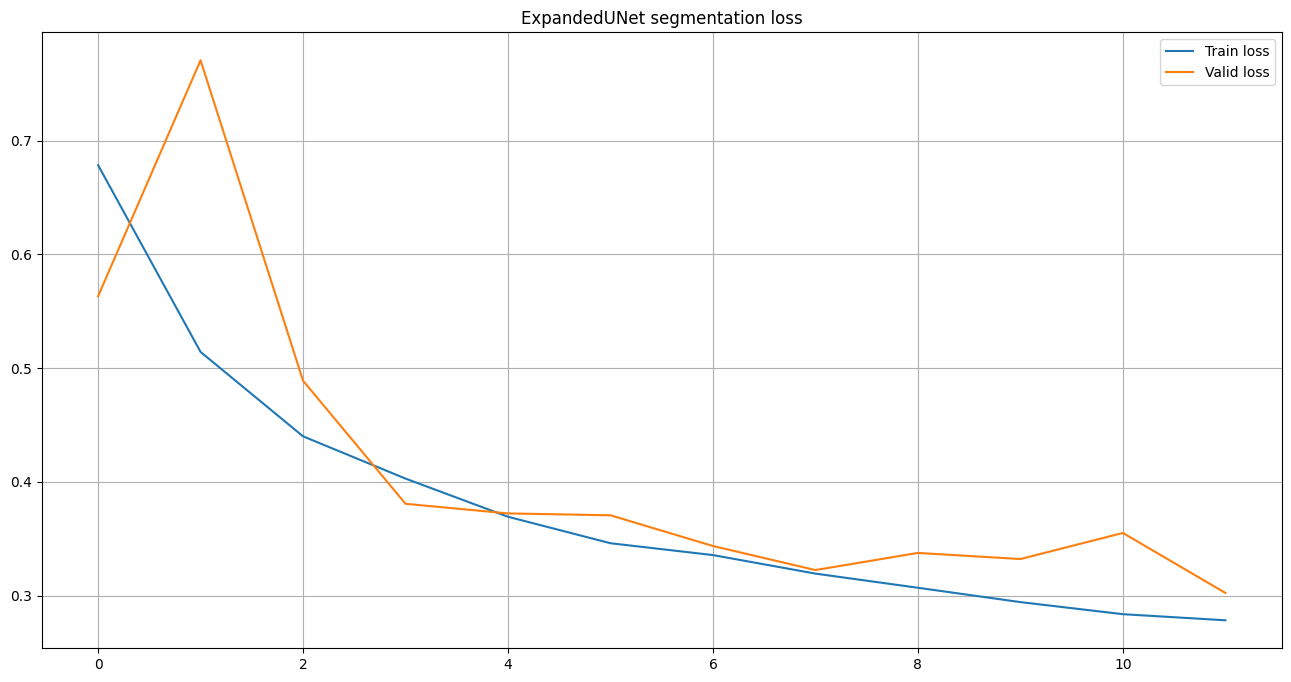

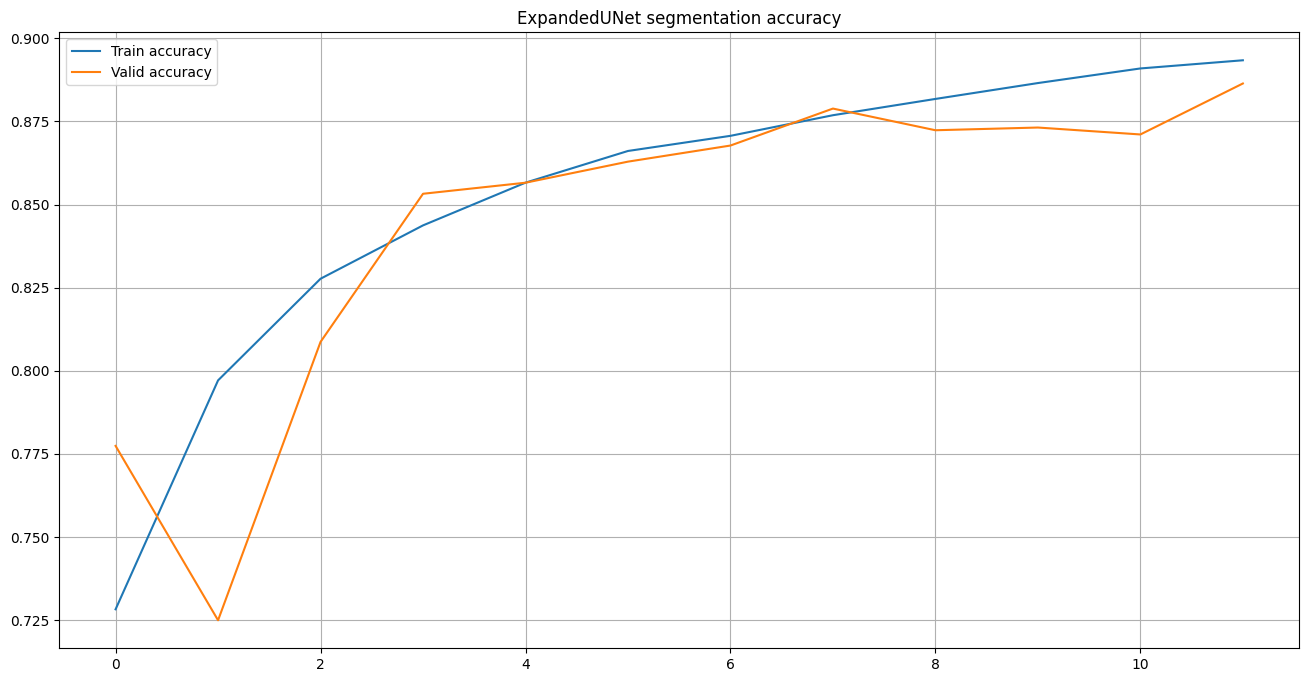

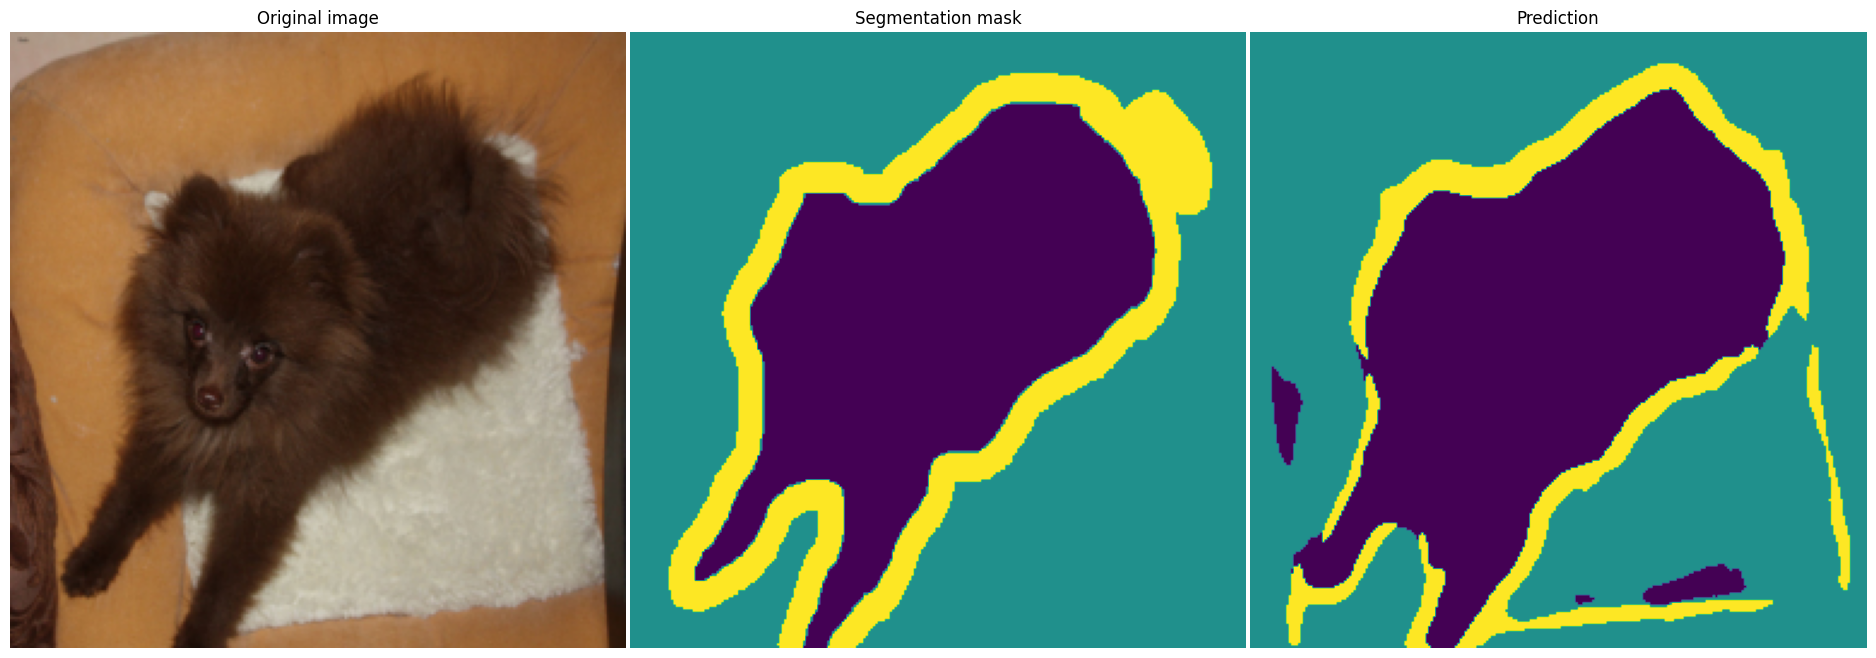

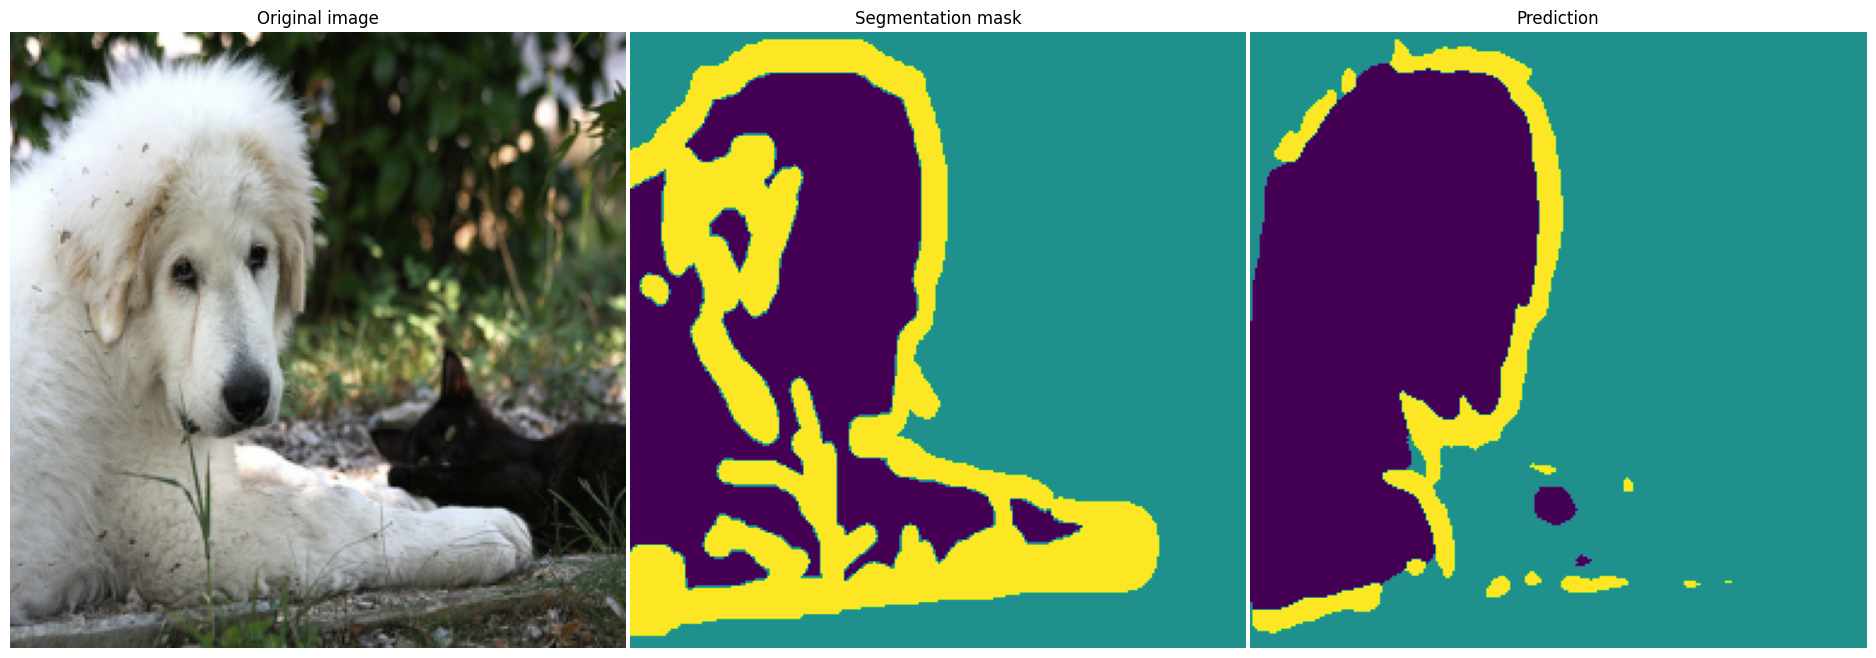

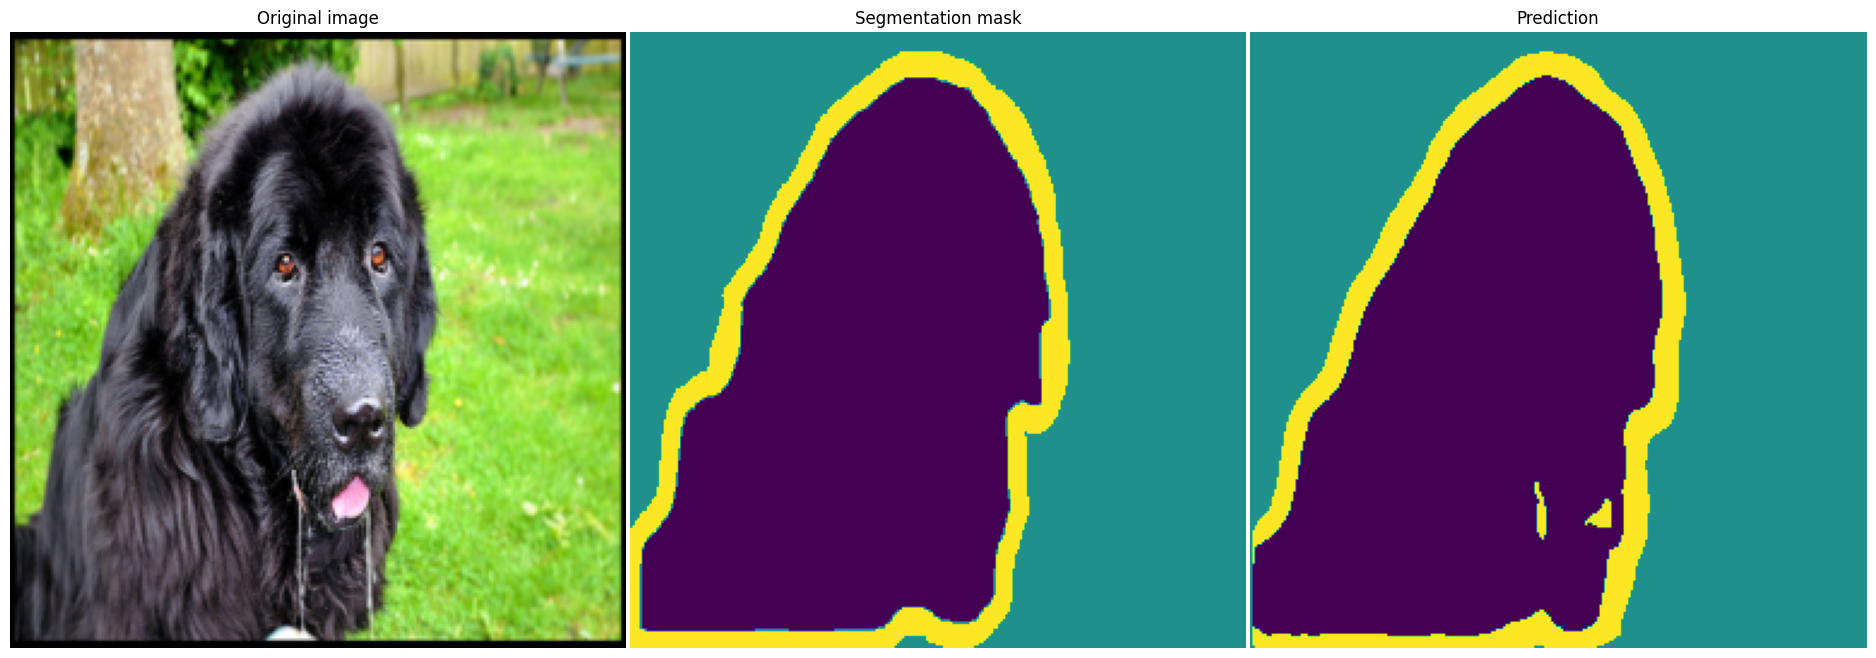

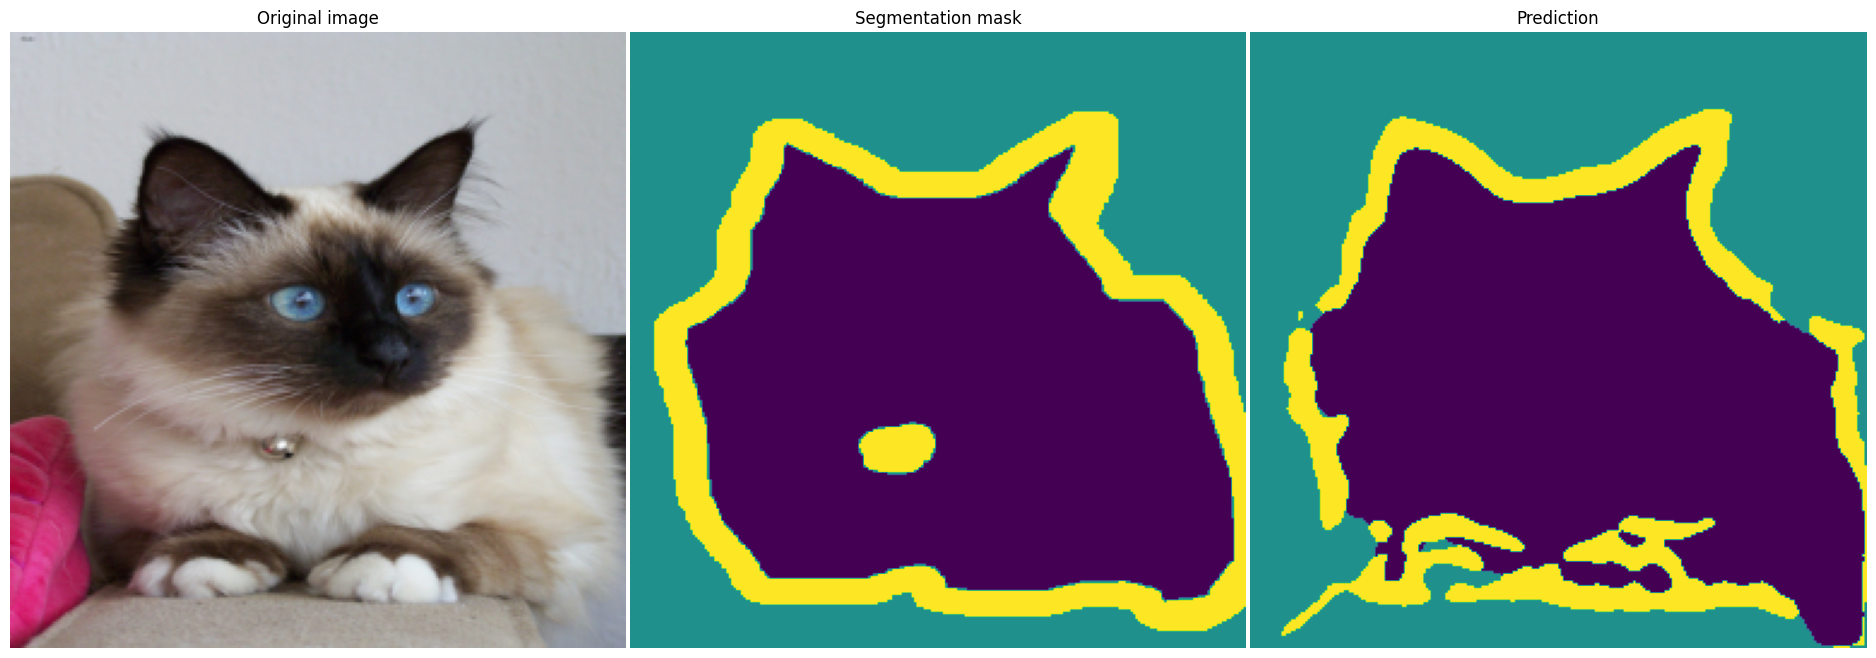

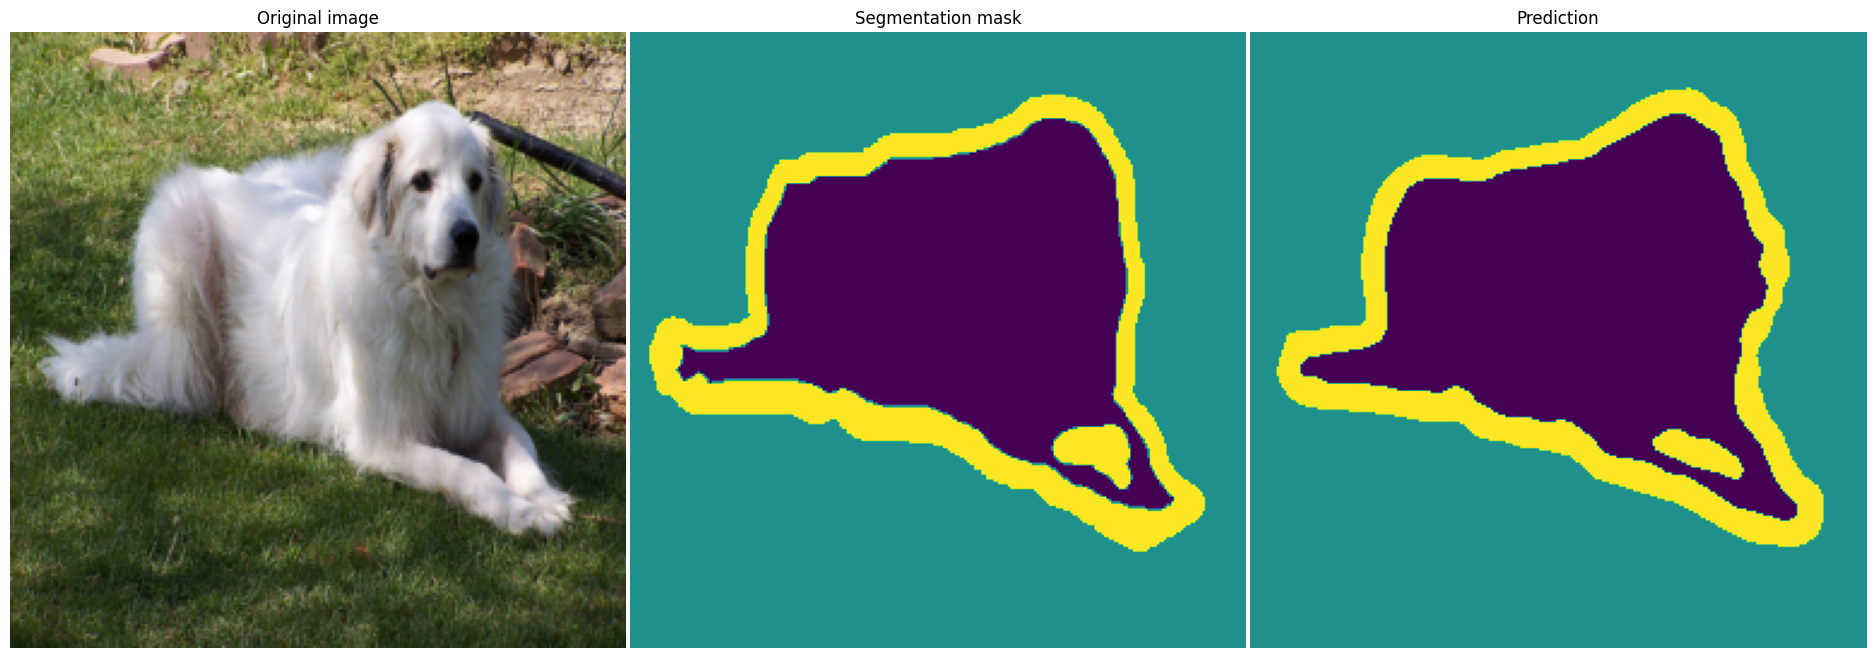

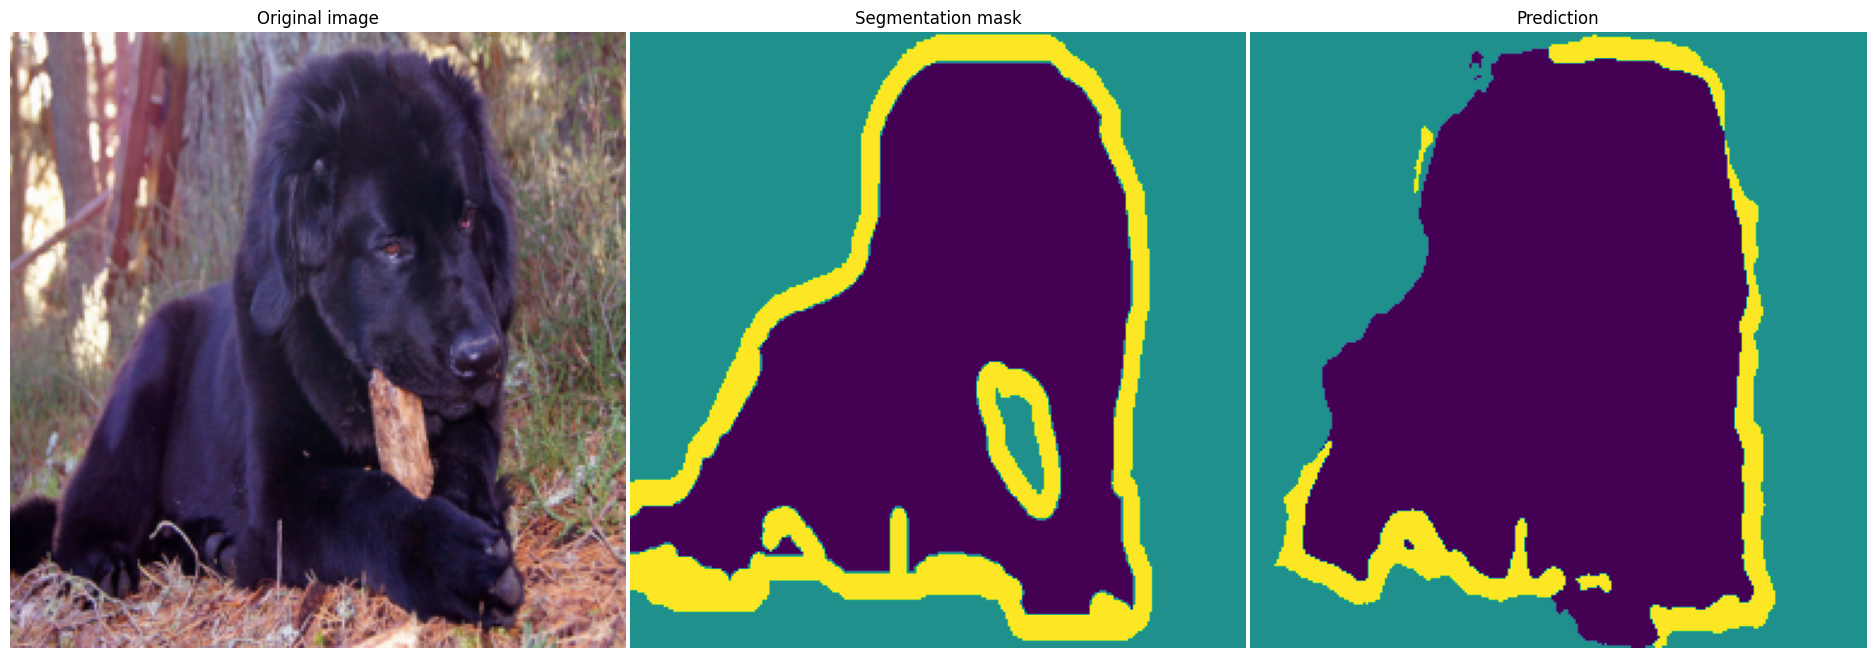

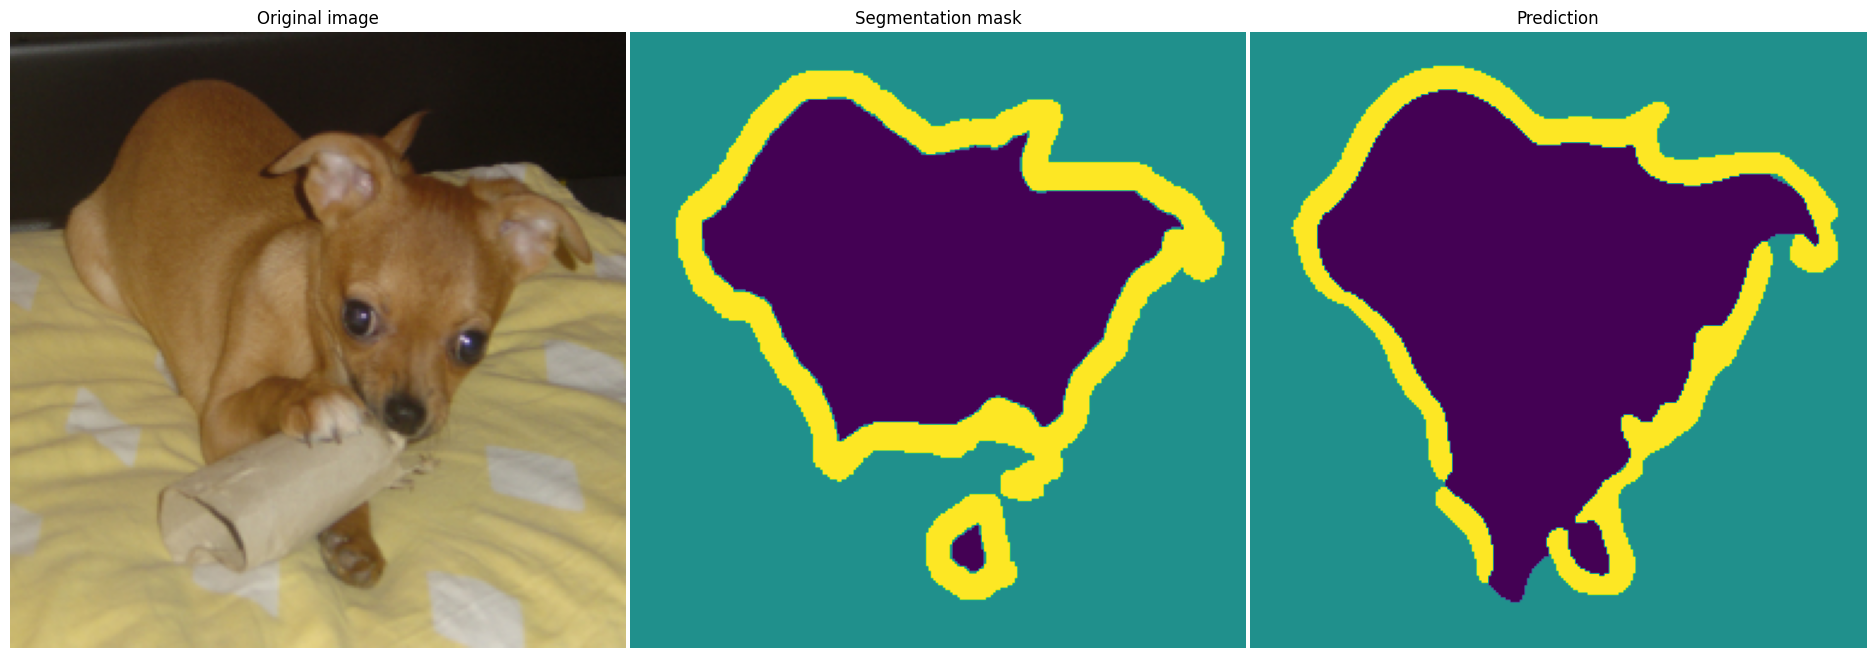

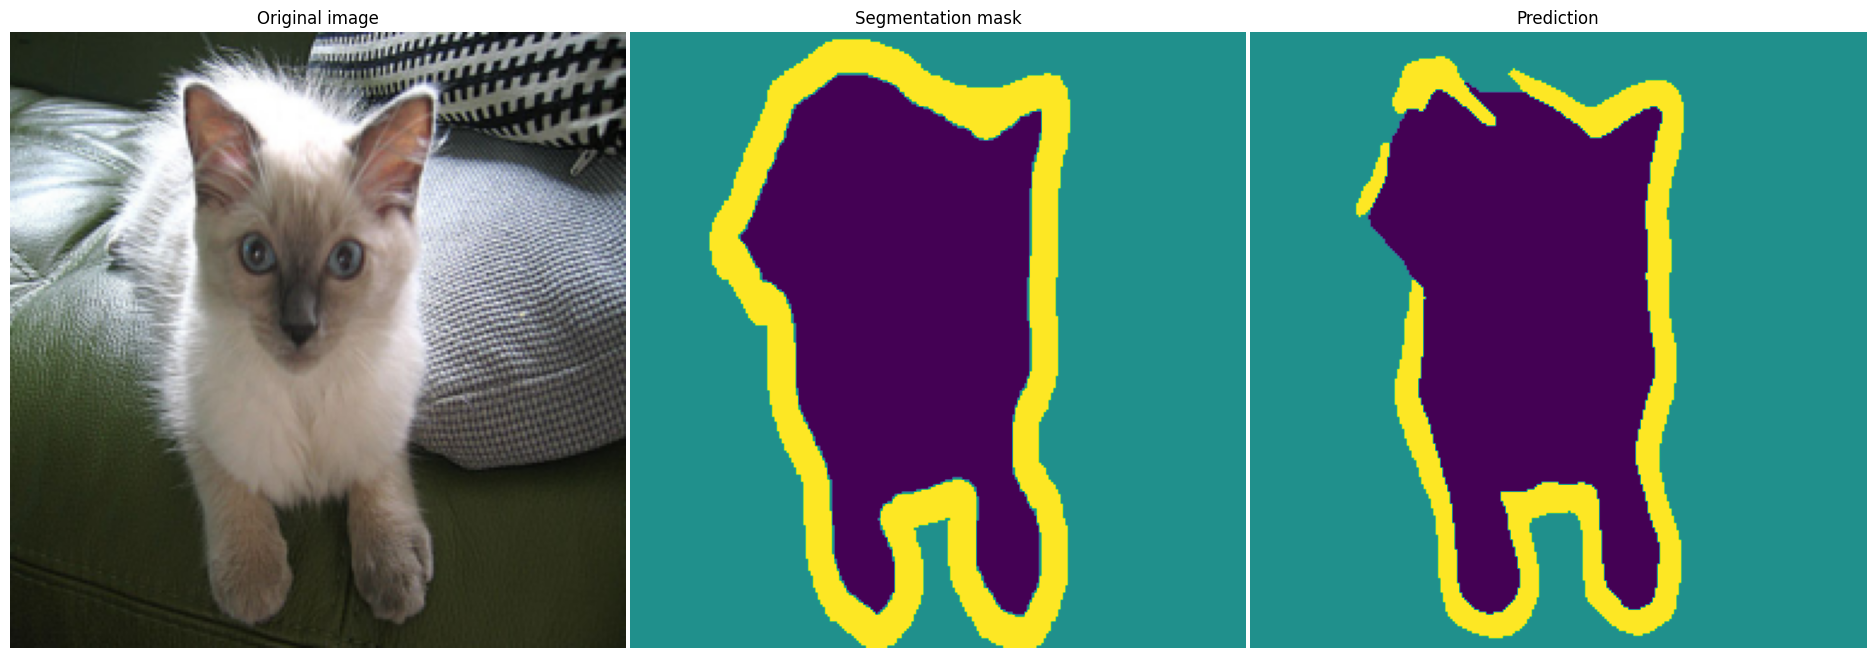

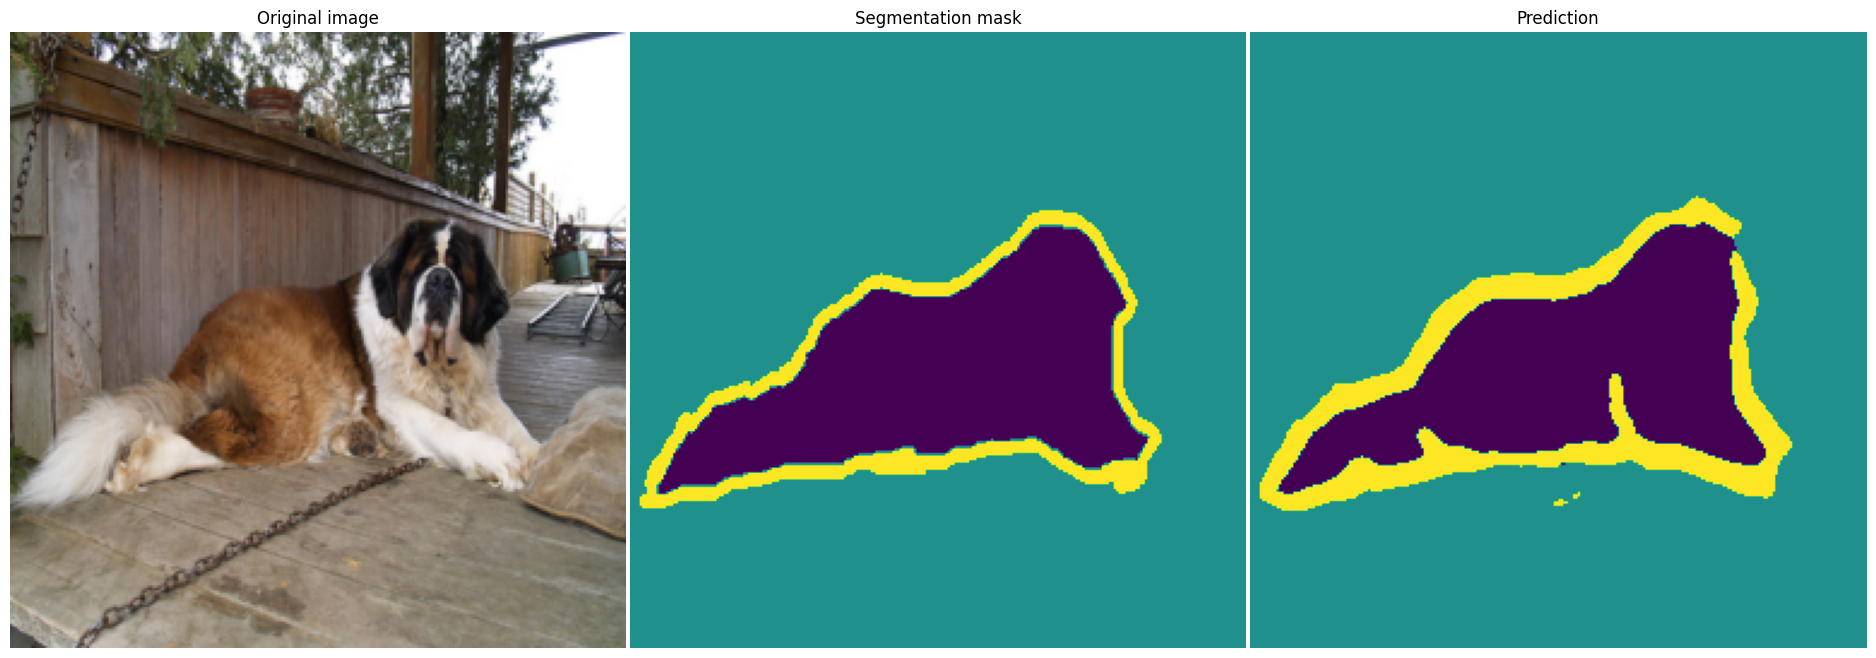

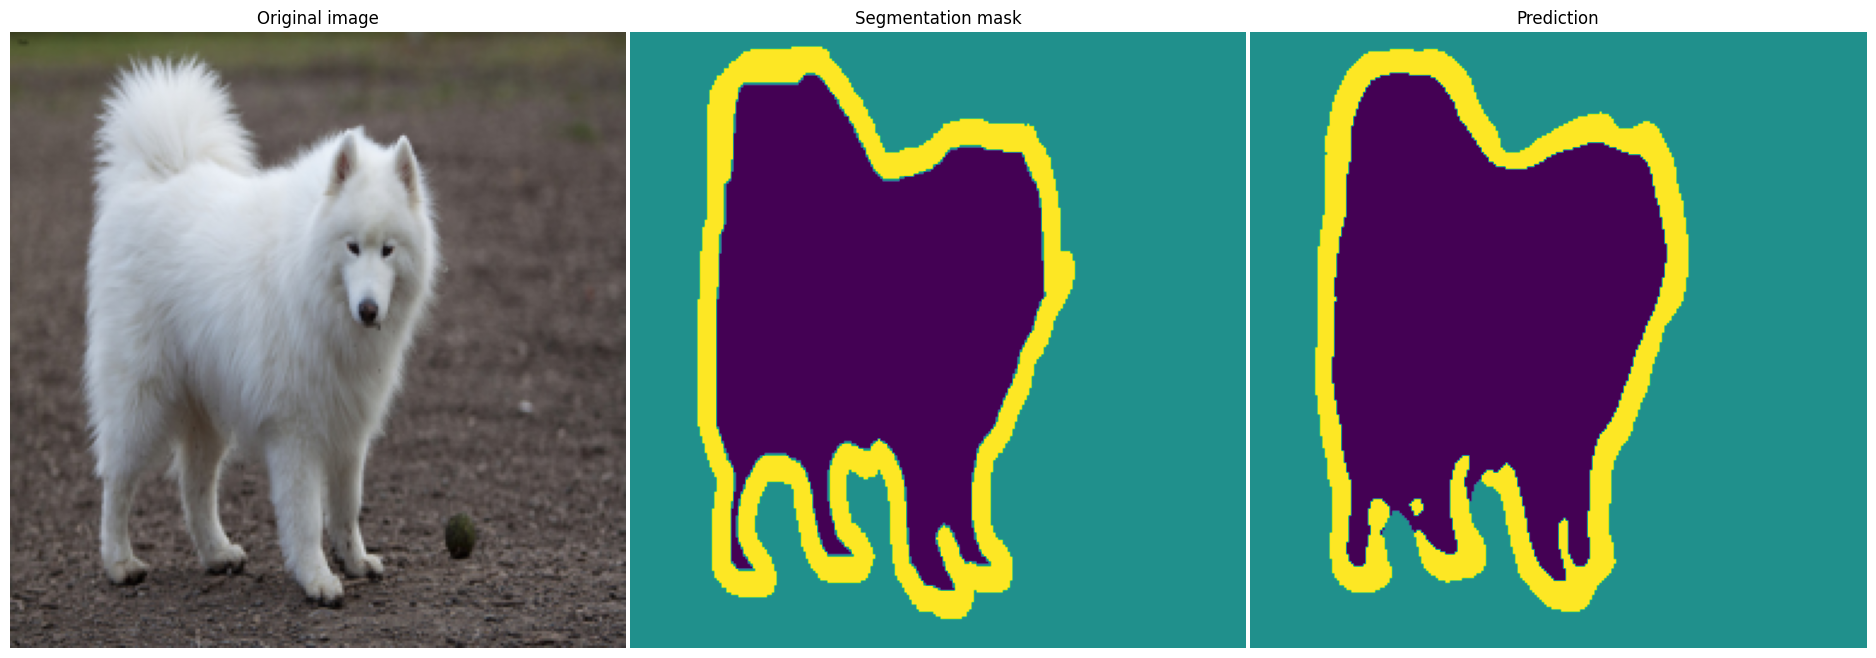

In [13]:
#!g1.1
whole_train_valid_cycle(model, 15, 'ExpandedUNet segmentation')

In [14]:
np.random.seed(100)
idx = np.random.randint(len(valid_dataset), size=200)
test_images = []

model.eval()
with torch.no_grad():
    for i in idx:
        x, _ = valid_dataset[i]
        test_images.append(model(x.unsqueeze(0).to(device)).squeeze(0).argmax(dim=0, keepdim=True))

test_predictions = torch.stack(test_images, dim=0)
torch.save(test_predictions, 'test_predictions.pt')